In [ ]:
#Importação da bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/main/dados_limpos.csv"
df = pd.read_csv(url, sep=",")

df.columns

from google.colab import files
uploaded = files.upload()
df_reais = pd.read_excel('PIB dos Municípios - base de dados 2010-2020.xls')


Saving PIB dos Municípios - base de dados 2010-2020.xls to PIB dos Municípios - base de dados 2010-2020.xls


In [ ]:
df_reais = df_reais.rename(columns={
    'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)': 'PIB',
    'Código do Município': 'CDMunicipio'
})

df_2020_real = df_reais[df_reais['Ano'] == 2020][['CDMunicipio', 'PIB']]

# ⚪**Aprendizado supervisionado e não-supervisionado - Economia**

Para esta etapa, a equipe utilizou algoritmos de aprendizado supervisionado e não supervisionado com o objetivo de verificar se é possível prever o PIB dos municípios para um determinado ano. Surge, então, a seguinte questão: **é viável estimar, por meio de um modelo, os valores do PIB dos municípios para um ano específico que não está presente no conjunto de dados utilizado para treinamento?**

Desse modo, para que o modelo seja construído de maneira sólida, inicialmente a equipe optou por realizar uma análise acerca das variáveis socioeconômicas que estão presentes no conjunto de dados (dataset) e podem ser de grande utilidade na previsão do PIB. Observa-se, então, a distribuição de algumas variáveis independentes com relação à dependente (PIB):



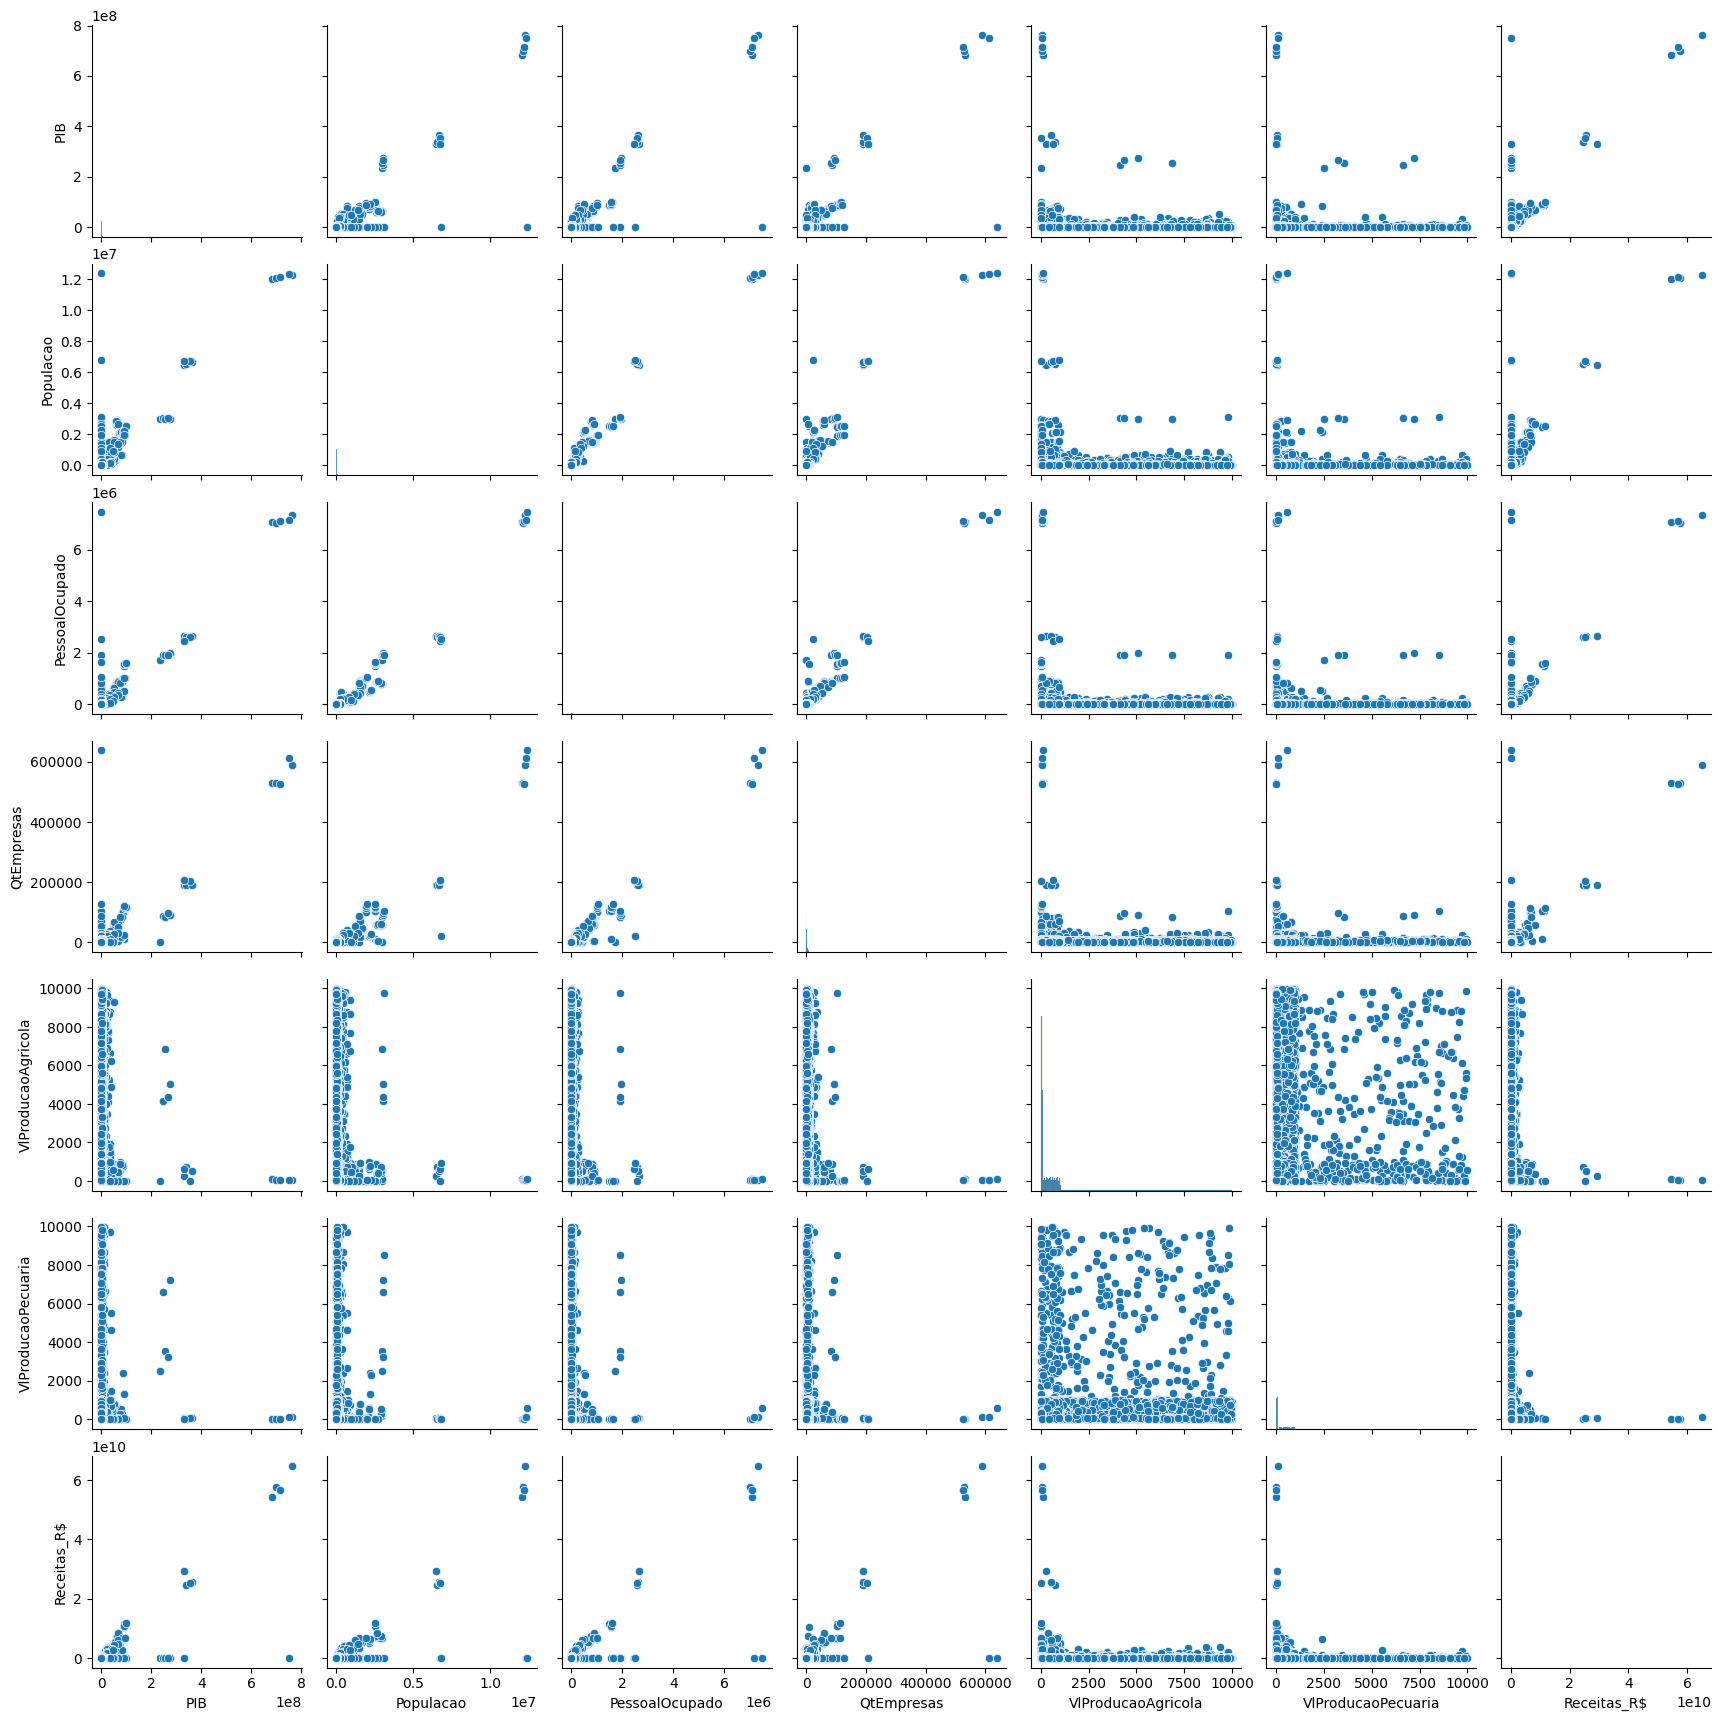

In [ ]:
sns.pairplot(df[['PIB','Populacao', 'PessoalOcupado', 'QtEmpresas','VlProducaoAgricola', 'VlProducaoPecuaria', 'Receitas_R$']])

Pode-se observar, com os gráficos de algumas das variáveis do dataset acima, que a maioria delas possui uma relação linear, de certa forma. Logo, apesar da equipe não ter criado o plot de todas as variáveis a serem utilizadas no modelo, elas se encontram a seguir:

    'Populacao', 'PessoalOcupado', 'PessoalAssalariado', 'QtEmpresas',
    'VlProducaoAgricola', 'VlProducaoPecuaria', 'Receitas_R$', 'PIB_PerCapita',
    'Densidade_Populacional', 'VrSalarios', 'Importacoes_US$', 'Exportacoes_US$',
    'Transferencias_correntes_R$', 'Transferencias_capital_R$',
    'NrNascimentos', 'NrObitosInfantis', 'Proporcao_PessoalAssalariado',
    'Proporcao_Area_Plantada', 'povoamento', 'Ano'

---



## **⭕ Aplicação do Modelo Não-Supervisionado**
Após realizar a análise das variáveis supracitadas, fora discutido sobre a implementação de um algoritmo de aprendizado não supervisionado, a fim de que o modelo realize agrupamentos dos dados baseado em suas semelhanças - **sem a utilização de rótulos**. Dessa maneira, o que for desenvolvido nessa etapa servirá de alicerce para a construção do modelo de aprendizado supervisionado posteriormente.

Sendo assim, fora aplicado no modelo o **algoritmo K-means**, que é responsável pelo agrupamento dos dados de acordo com as variáveis e a criação de clusters. Neste caso do PIB, a melhor escolha de quantidade de cluster de acordo com o teste de silhueta (avalia a qualidade de um grupo de dados) foi **três (3)** . Ademais, para facilitar a visualização dos agrupamentos, foi utilizada a técnica de **PCA** (Análise de Componentes Principais), que reduziu a dimensionalidade dos dados, permitindo representar os clusters em um gráfico bidimensional.

Por fim, como forma de avaliação da qualidade dos clusters antes de implementar o modelo supervisionado, foi utilizado o algoritmo **Gradient Boosting Regressor** em cada grupo para verificar a capacidade de precição que há internamente. Vale destacar que, nesta etapa, o modelo ainda não está sendo usado para prever o PIB final, mas apenas para avaliar a coerência dos agrupamentos que foram, então, formados.



In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

df['Log_Populacao'] = np.log1p(df['Populacao'])
df['Receitas_por_Habitante'] = df['Receitas_R$'] / (df['Populacao'] + 1)
df['Comercio_Exterior'] = df['Importacoes_US$'] + df['Exportacoes_US$']
df['Saldo_Transferencias'] = df['Transferencias_correntes_R$'] - df['Transferencias_capital_R$']

variaveis_preditoras = [
    'Log_Populacao', 'PessoalOcupado', 'VrSalarios', 'PIB_PerCapita',
    'Receitas_por_Habitante', 'Comercio_Exterior', 'Saldo_Transferencias',
    'Ano', 'VlProducaoAgricola', 'VlProducaoPecuaria'
]

def limpar_dados(df, vars_interesse, remover_outliers=True):
    df_limpo = df.copy()
    df_limpo[vars_interesse] = df_limpo[vars_interesse].fillna(df_limpo[vars_interesse].median())
    if remover_outliers:
        from scipy.stats import zscore
        z_scores = df_limpo[vars_interesse].apply(zscore)
        mask_outliers = (np.abs(z_scores) < 3).all(axis=1)
        df_limpo = df_limpo[mask_outliers].copy()
    return df_limpo

df_treino = df[df['Ano'] < 2020].copy()
df_predicao = df[df['Ano'] == 2020].copy()

df_treino_limpo = limpar_dados(df_treino, variaveis_preditoras + ['PIB'])
df_predicao_limpo = limpar_dados(df_predicao, variaveis_preditoras, remover_outliers=False)
print("✅ Dados limpos e separados")

✅ Dados limpos e separados


Com relação ao tratamento dos dados para criação e análise do modelo, inicialmente os valores ausentes nas variáveis de interesse foram preenchidos com a **mediana**, de maneira a evitar possíveis distorções que poderiam ocorrer com o uso da média.

Além disso, fora aplicada uma técnica para remoção dos outliers baseada no **z-score**, que avalia o quão distante cada observação está da média da sua variável, em unidades de desvio padrão. Observações com z-score absoluto maiores que 3 foram consideradas estranhas e, portanto, removidas do conjunto de treino. Tal filtragem surgiu com o intuito de reduzir o impactos de valores que estão nas extremidades e poderiam comprometer ainda mais a performance do modelo.


📊 Silhouette Score (k=3): 0.2526

📊 Distribuição por cluster:
  Cluster 0: 6168 municípios (30.3%)
  Cluster 1: 13524 municípios (66.5%)
  Cluster 2: 651 municípios (3.2%)

📈 Métricas por cluster (modelo: GradientBoosting):
  Cluster 0: R² = 0.9984 | MAE = R$ 5,236 | Amostras: 6168
  Cluster 1: R² = 0.9961 | MAE = R$ 12,846 | Amostras: 13524
  Cluster 2: R² = 0.9489 | MAE = R$ 482,280 | Amostras: 651


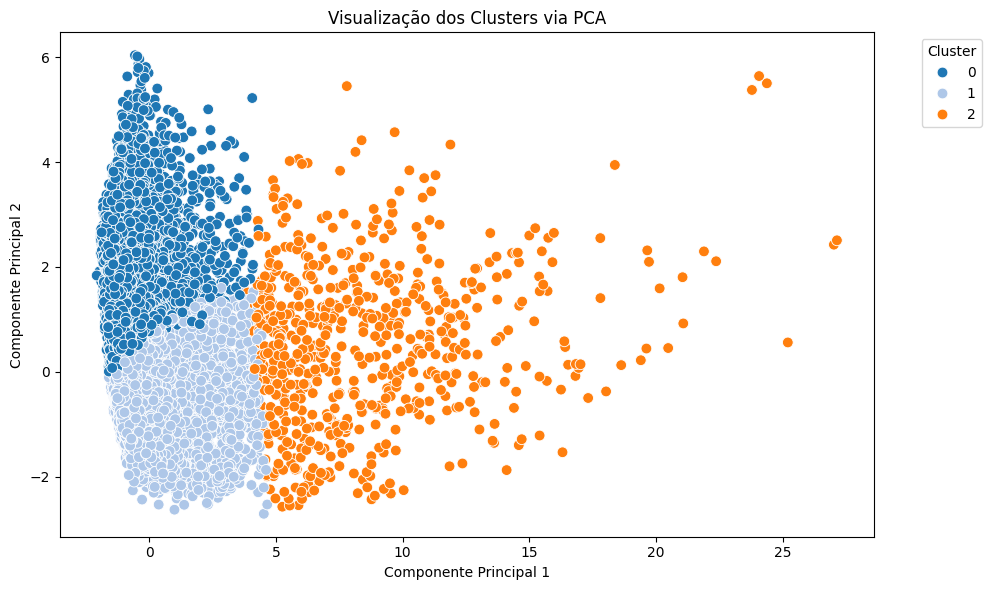

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterização
X_cluster = StandardScaler().fit_transform(df_treino_limpo[variaveis_preditoras])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_treino_limpo['cluster'] = kmeans.fit_predict(X_cluster)

# Aplicar nos dados de predição
scaler_cluster = StandardScaler().fit(df_treino_limpo[variaveis_preditoras])
df_predicao_limpo['cluster'] = kmeans.predict(scaler_cluster.transform(df_predicao_limpo[variaveis_preditoras]))

# Métrica de qualidade dos clusters
silhouette = silhouette_score(X_cluster, df_treino_limpo['cluster'])
print(f"\n📊 Silhouette Score (k=3): {silhouette:.4f}")

# Distribuição por cluster
print("\n📊 Distribuição por cluster:")
for i in sorted(df_treino_limpo['cluster'].unique()):
    n = (df_treino_limpo['cluster'] == i).sum()
    pct = n / len(df_treino_limpo) * 100
    print(f"  Cluster {i}: {n} municípios ({pct:.1f}%)")

# Avaliação supervisionada (modelo Gradient Boosting)
print("\n📈 Métricas por cluster (modelo: GradientBoosting):")
for cluster_id in sorted(df_treino_limpo['cluster'].unique()):
    dados_cluster = df_treino_limpo[df_treino_limpo['cluster'] == cluster_id].copy()
    if len(dados_cluster) < 20:
        print(f"  ⚠ Cluster {cluster_id} ignorado (menos de 20 amostras)")
        continue

    X = dados_cluster[variaveis_preditoras]
    y = np.log1p(dados_cluster['PIB'])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    modelo = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
    modelo.fit(X_train_scaled, y_train)
    y_pred_log = modelo.predict(X_val_scaled)

    y_real = np.expm1(y_val)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    print(f"  Cluster {cluster_id}: R² = {r2:.4f} | MAE = R$ {mae:,.0f} | Amostras: {len(dados_cluster)}")

# Visualização dos clusters com PCA
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(StandardScaler().fit_transform(df_treino_limpo[variaveis_preditoras]))
df_plot = pd.DataFrame(dados_pca, columns=['Componente 1', 'Componente 2'])
df_plot['Cluster'] = df_treino_limpo['cluster'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='Componente 1', y='Componente 2', hue='Cluster', palette='tab20', s=60)
plt.title('Visualização dos Clusters via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Assim, a análise da imagem acima reflete os agrupamentos obtidos pelo K-means e projetados por PCA. O Silhouette Score de **0.2526** indica uma separação bem mediana entre os grupos formados. A interpretação dos clusters, com base na distribuição, fora:

  * Cluster 0:  corresponde a **30,3%** dos municípios, possivelmente com perfis socioeconômicos medianos  e que talvez sejam agrícolas, urbanos médios, entre outros. Com um baixo erro médio absoluto (MAE), o modelo consegue prever o PIB com **alta precisão** nesse cluster, por serem municípios mais padronizados e previsiveis. 🌱

  * Cluster 1:  agrupa **66,5%** das cidades, representando a maioria delas, com perfis socioeconômicos semelhantes e características comuns entre si. Como é o maior grupo e o MAE não altera muito o valor com relação ao cluster 0, o modelo tende a funcionar bem para a maioria das cidades nesse agrupamento também. 🌆

  * Cluster 2: apenas **3,2%** dos municípios, sugerindo cidades com perfis mais atípicos — como muito ricos ou pobres, isolados, ou extremos de alguma forma. O MAE, nesse caso, é muito maior, o que reflete uma alta variabilidade e uma d**ificuldade de predição** do PIB para 2020 nessas cidades, devido ao fato de ser um grupo bem menor e extremamente heterogêneo (tanto PIB's muito alto, quanto muito baixos). 💸
  
Um ponto importante a ser ressaltado também é o certo acumulo dos municípios plotados no gráfico na região esquerda. Tal distribuição assimétrica ocorre devido à **alta semelhança dos municípios uns com os outros** e não significa que haja um erro, mas sim que a maior parte das cidades tem características concentradas dentro de um espaço menor de variabilidade. 🌍


---






## ⭕ **Aplicação do modelo supervisionado**

Nesta etapa, aplicou-se modelos supervisionados para prever o PIB dos municípios, utilizando uma abordagem por cluster. Após a clusterização, treinamos um modelo específico para cada grupo de municípios, aproveitando características semelhantes entre eles.

Utilizou-se um modelo empilhado (Stacking Regressor), que combina três algoritmos de aprendizado supervisionado:

**GradientBoostingRegressor**: bom para capturar relações não-lineares e interações entre variáveis;

**RandomForestRegressor**: robusto a outliers e eficaz para dados tabulares;

**XGBoost**: modelo potente e eficiente, amplamente usado em competições de machine learning.

Esses três modelos base são combinados por um estimador final (RidgeCV), que aprende a melhor forma de ponderar as predições dos modelos anteriores.

Para cada cluster, foram selecionados apenas os dados pertencentes àquele grupo e aplicou-se o logaritmo natural com deslocamento (**log1p**) sobre os valores do PIB, com o objetivo de estabilizar a variância e melhorar a performance dos modelos. Em seguida, foi feita a validação cruzada temporal utilizando o **TimeSeriesSplit** com 4 divisões, permitindo avaliar a capacidade de generalização do modelo dentro do próprio cluster, respeitando a ordem temporal dos dados. As predições geradas durante a validação são revertidas para a escala original do PIB por meio da função **expm1**, que desfaz a transformação logarítmica. Após essa etapa, o modelo foi treinado com todos os dados do cluster e foi utilizado para prever o PIB de 2020 dos municípios que pertencem ao mesmo grupo, garantindo que cada predição esteja contextualizada com base no padrão histórico do seu respectivo cluster.


In [ ]:
estimadores = [
    ('gb', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0))
]
modelo_stack = StackingRegressor(estimators=estimadores, final_estimator=RidgeCV(), n_jobs=-1)

predicoes_stack = []
for cluster_id in sorted(df_treino_limpo['cluster'].unique()):
    dados_cluster = df_treino_limpo[df_treino_limpo['cluster'] == cluster_id].copy()
    if len(dados_cluster) < 20:
        continue
    X = dados_cluster[variaveis_preditoras]
    y = np.log1p(dados_cluster['PIB'])

    tscv = TimeSeriesSplit(n_splits=4)
    pipeline = make_pipeline(StandardScaler(), modelo_stack)
    y_real_total, y_pred_total = [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelo = clone(pipeline)
        modelo.fit(X_train, y_train)
        y_pred_log = modelo.predict(X_test)
        y_real_total.extend(np.expm1(y_test))
        y_pred_total.extend(np.expm1(y_pred_log))

    pipeline.fit(X, y)
    dados_pred = df_predicao_limpo[df_predicao_limpo['cluster'] == cluster_id].copy()
    if not dados_pred.empty:
        X_pred = dados_pred[variaveis_preditoras]
        dados_pred['PIB_Predito'] = np.expm1(pipeline.predict(X_pred))
        dados_pred['Modelo_Cluster'] = cluster_id
        predicoes_stack.append(dados_pred)

print("✅ Modelos treinados e predições geradas")

✅ Modelos treinados e predições geradas


##⭕ **Estatísticas Globais e Análise das Predições**

Nesta etapa, consolidou-se os resultados do modelo supervisionado que foi treinado e avaliado por clusters. Para isso, foi utilizado um dataset externo contendo os valores reais do PIB dos municípios no ano de 2020, o que permitiu comparar as predições do modelo com os dados observados.

A seguir, foram feitos cálculos das métricas globais de desempenho para quantificar a qualidade geral das predições feitas para o PIB dos municípios em 2020.

* **Cálculo de métricas globais de desempenho**, incluindo:

  * **MAE (Erro Absoluto Médio)**: que mede a média das diferenças absolutas entre os valores reais e preditos do PIB, indicando o erro médio em reais.
  * **R² (Coeficiente de Determinação)**: que indica a proporção da variância dos dados reais explicada pelo modelo.
  * **Silhouette Score**: que avalia a qualidade da clusterização utilizada antes da modelagem, garantindo que os grupos de municípios formados são coesos.
  * **Média e desvio padrão do PIB real**: para contextualizar os valores preditos e os erros encontrados.
  * **Erro percentual médio**: que relaciona o MAE à média do PIB, dando uma noção do erro em termos relativos.

Após calcular as métricas globais, realizou-se uma análise das melhores predições ordenando os municípios pelas menores taxas de erro percentual e selecionando os 10 municípios com melhor desempenho preditivo. Para esses municípios, é apresentado os valores de PIB real, PIB predito, erro absoluto e percentual, todos formatados de maneira clara e legível em termos monetários. Além disso, exibe-se uma amostra aleatória de 10 predições, o que permite uma inspeção mais ampla da qualidade preditiva em diferentes contextos regionais, utilizando os mesmos campos das melhores predições para facilitar a comparação.

Os resultados das métricas e as tabelas com as melhores predições e predições aleatórias estão mostrados abaixo para análise e interpretação.


In [ ]:
if predicoes_stack:
    import random

    df_predicoes_stack = pd.concat(predicoes_stack, ignore_index=True)
    comparacao = df_predicoes_stack.merge(df_2020_real[['CDMunicipio', 'PIB']], on='CDMunicipio', how='inner')

    y_test = comparacao['PIB_y']
    y_pred = comparacao['PIB_Predito']

    # Estatísticas globais
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    media_pib = y_test.mean()
    desvio_pib = y_test.std()
    erro_pct = (mae / media_pib) * 100

    print("\n📊 ESTATÍSTICAS DO MODELO SUPERVISIONADO:")
    print(f"➡ MAE: R$ {mae:,.2f}")
    print(f"➡ R²: {r2:.4f}")
    print(f"➡ Silhouette Score: {silhouette:.4f}")
    print(f"📌 Média do PIB real: R$ {media_pib:,.2f}")
    print(f"📉 Desvio padrão do PIB: R$ {desvio_pib:,.2f}")
    print(f"📈 Erro percentual médio: {erro_pct:.2f}%")


    # Cálculo de erros
    comparacao['Erro_Absoluto'] = abs(comparacao['PIB_y'] - comparacao['PIB_Predito'])
    comparacao['Erro_Percentual'] = abs((comparacao['PIB_y'] - comparacao['PIB_Predito']) / comparacao['PIB_y']) * 100

    # Melhores predições (menor erro percentual)
    melhores = comparacao.sort_values(by='Erro_Percentual').head(10).copy()
    melhores['PIB_y'] = melhores['PIB_y'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    melhores['PIB_Predito'] = melhores['PIB_Predito'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    melhores['Erro_Absoluto'] = melhores['Erro_Absoluto'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    melhores['Erro_Percentual'] = melhores['Erro_Percentual'].apply(lambda x: f"{x:.2f}%")
    print("✅ TOP 10 MELHORES PREDIÇÕES (menor erro percentual):")
    display(melhores[['Municipio', 'UF', 'PIB_y', 'PIB_Predito', 'Erro_Absoluto', 'Erro_Percentual']])

    # 10 predições aleatórias
    aleatorios = comparacao.sample(10, random_state=42).copy()
    aleatorios['PIB_y'] = aleatorios['PIB_y'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    aleatorios['PIB_Predito'] = aleatorios['PIB_Predito'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    aleatorios['Erro_Absoluto'] = aleatorios['Erro_Absoluto'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    aleatorios['Erro_Percentual'] = aleatorios['Erro_Percentual'].apply(lambda x: f"{x:.2f}%")
    print("🔍 10 PREDIÇÕES ALEATÓRIAS PARA ANÁLISE:")
    display(aleatorios[['Municipio', 'UF', 'PIB_y', 'PIB_Predito', 'Erro_Absoluto', 'Erro_Percentual']])
else:
    print("⚠ Nenhuma predição foi realizada.")



📊 ESTATÍSTICAS DO MODELO SUPERVISIONADO:
➡ MAE: R$ 513,553.41
➡ R²: 0.1387
➡ Silhouette Score: 0.2526
📌 Média do PIB real: R$ 1,366,175.40
📉 Desvio padrão do PIB: R$ 12,369,552.72
📈 Erro percentual médio: 37.59%
✅ TOP 10 MELHORES PREDIÇÕES (menor erro percentual):


,Municipio,UF,PIB_y,PIB_Predito,Erro_Absoluto,Erro_Percentual
3494,Caridade do Piauí,PI,"R$ 50.227,90","R$ 50.228,25","R$ 0,35",0.00%
996,Camanducaia,MG,"R$ 749.781,89","R$ 749.798,87","R$ 16,97",0.00%
1177,Ituporanga,SC,"R$ 1.109.875,67","R$ 1.109.844,46","R$ 31,20",0.00%
4488,Silva Jardim,RJ,"R$ 559.967,40","R$ 559.985,04","R$ 17,64",0.00%
3827,Careiro,AM,"R$ 363.553,43","R$ 363.569,28","R$ 15,85",0.00%
678,Joaíma,MG,"R$ 160.121,01","R$ 160.113,78","R$ 7,23",0.00%
3906,Buriti dos Montes,PI,"R$ 69.126,83","R$ 69.123,37","R$ 3,46",0.01%
2614,Andrelândia,MG,"R$ 249.222,62","R$ 249.238,89","R$ 16,27",0.01%
2904,Itauçu,GO,"R$ 180.909,58","R$ 180.922,49","R$ 12,92",0.01%
1204,Bandeirantes,PR,"R$ 1.004.320,62","R$ 1.004.395,52","R$ 74,90",0.01%


🔍 10 PREDIÇÕES ALEATÓRIAS PARA ANÁLISE:


,Municipio,UF,PIB_y,PIB_Predito,Erro_Absoluto,Erro_Percentual
1168,Nova Brasilândia DOeste,RO,"R$ 403.369,81","R$ 403.494,26","R$ 124,45",0.03%
765,Lajinha,MG,"R$ 374.174,89","R$ 394.107,58","R$ 19.932,69",5.33%
465,Nilópolis,RJ,"R$ 2.984.860,87","R$ 3.143.766,83","R$ 158.905,96",5.32%
1117,Tucuruí,PA,"R$ 4.568.225,60","R$ 5.313.177,64","R$ 744.952,03",16.31%
5193,Santa Rosa do Purus,AC,"R$ 84.136,95","R$ 91.419,02","R$ 7.282,08",8.66%
1433,Picos,PI,"R$ 1.760.580,53","R$ 1.931.928,25","R$ 171.347,72",9.73%
4800,Seritinga,MG,"R$ 42.468,65","R$ 82.139,16","R$ 39.670,51",93.41%
611,Três Cachoeiras,RS,"R$ 267.519,07","R$ 283.527,36","R$ 16.008,30",5.98%
230,Parazinho,RN,"R$ 400.915,07","R$ 395.578,30","R$ 5.336,76",1.33%
926,Nova Nazaré,MT,"R$ 100.665,18","R$ 107.956,69","R$ 7.291,51",7.24%


Os resultados mostram que o modelo apresenta um MAE relativamente alto, indicando que, em média, as previsões do PIB divergem significativamente dos valores reais, o que é esperado dada a alta variabilidade econômica entre municípios, refletida no grande desvio padrão do PIB real. O R² baixo aponta que o modelo captura apenas uma pequena parte da variação do PIB, evidenciando as limitações em representar fatores externos complexos que influenciam a economia local. O Silhouette Score moderado indica que a clusterização prévia segmentou os municípios em grupos com separação razoável, mas ainda passível de aprimoramento para melhorar a modelagem por perfil. Por fim, o erro percentual médio elevado reforça a dificuldade do modelo em gerar previsões precisas em termos relativos, devido à heterogeneidade e à complexidade dos dados econômicos.

Os 10 municípios com as melhores predições mostraram erros percentuais muito baixos, indicando que o modelo conseguiu estimar o PIB com alta precisão nesses casos, provavelmente devido a perfis econômicos mais estáveis ou dados mais consistentes. Já as 10 predições aleatórias apresentaram maior variabilidade nos erros, incluindo alguns municípios com erros percentuais e absolutos significativos, refletindo a diversidade e complexidade dos contextos regionais que tornam a previsão do PIB mais desafiadora em certas localidades. Isso destaca que, apesar do bom desempenho em alguns casos, o modelo ainda enfrenta dificuldades para generalizar perfeitamente para todas as regiões.


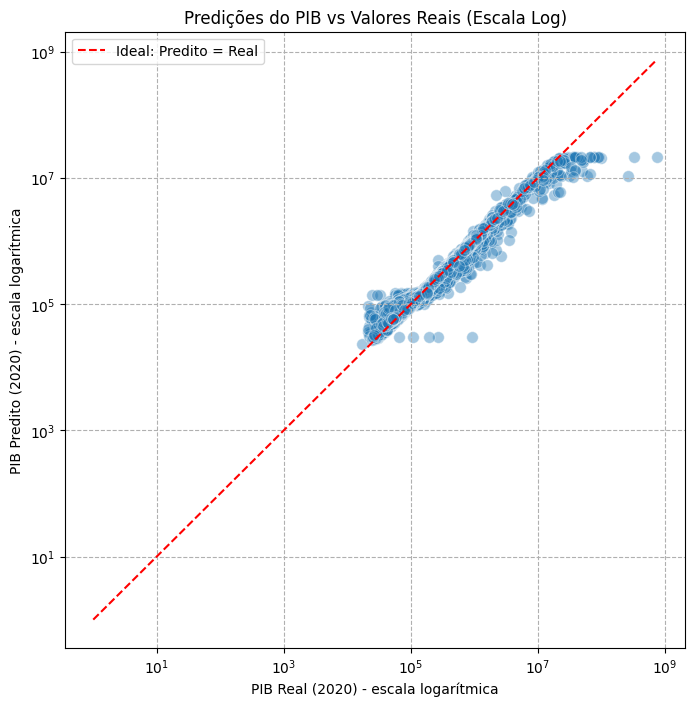

In [20]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=comparacao['PIB_y'], y=comparacao['PIB_Predito'], alpha=0.4, s=70)
max_val = max(comparacao['PIB_y'].max(), comparacao['PIB_Predito'].max())

plt.plot([1, max_val], [1, max_val], color='red', linestyle='--', label='Ideal: Predito = Real')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('PIB Real (2020) - escala logarítmica')
plt.ylabel('PIB Predito (2020) - escala logarítmica')
plt.title('Predições do PIB vs Valores Reais (Escala Log)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Foi gerado um gráfico de dispersão comparando os valores reais do PIB dos municípios com as predições do modelo empilhado (Stacking Regressor). No gráfico, a maioria dos pontos está próxima da linha ideal de predição, indicando boa concordância entre valores previstos e reais na maior parte dos casos. Entretanto, observa-se maior dispersão especialmente nos valores extremos do PIB, refletindo a dificuldade do modelo em prever corretamente municípios com PIB muito baixo ou muito alto. Essa variação é comum em modelos econômicos devido à complexidade e heterogeneidade dos dados. O gráfico ajuda a visualizar essas limitações e a distribuição dos erros, complementando as métricas quantitativas apresentadas.


## ⭕ **Conclusão**

Considerando toda a análise realizada, a combinação da clusterização não supervisionada com modelos preditivos permitiu identificar grupos de municípios com características econômicas semelhantes, possibilitando o uso de modelos especializados para cada segmento e, consequentemente, melhorando a precisão das previsões do PIB. Embora as métricas indicam limitações na capacidade dos modelos em capturar toda a variabilidade dos dados, os resultados demonstram que é viável obter previsões satisfatórias especialmente para municípios com perfis econômicos mais homogêneos. A alta dispersão dos valores do PIB e a complexidade das influências locais reforçam a necessidade de incorporar variáveis adicionais e aprimorar as técnicas de agrupamento e modelagem.
